In [1]:
#Pre-Processing
import os
import re
import torch
import random
import itertools

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# For visualising metrics
from visdom import Visdom

# For visualising gradients plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("The device found: "+str(device))

The device found: cuda


In [5]:

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

In [6]:
path='C:\\Users\\deepa\\Conversational Agents\\Datasets'
dataset='cornell movie-dialogs corpus'

data_folder=os.path.join(path,dataset)

print("The final data corpus folder: "+str(data_folder))

The final data corpus folder: C:\Users\deepa\Conversational Agents\Datasets\cornell movie-dialogs corpus


In [7]:
def get_lines_conversations():
    """
    Loads movie lines and conversations from the dataset.
    
    data_folder: Destination where conversations and lines are stored.
    
    movie_lines: Consist of movie lines as given by the dataset.
    movie_conversations: Consist of movie conversations as given by the dataset.
    
    """
    f=open(os.path.join(data_folder,'movie_lines.txt'),'r')
    movie_lines=f.read().splitlines()
    f.close()
    
    f=open(os.path.join(data_folder,'movie_conversations.txt'),'r')
    movie_conversations=f.read().splitlines()
    f.close()
    
    return movie_lines,movie_conversations


In [8]:
movie_lines,movie_conversations=get_lines_conversations()

print("Number of distinct lines: "+str(len(movie_lines)))
print("Number of conversations: "+str(len(movie_conversations)))
print("Average Number of lines per conversations: "+str(len(movie_lines)/len(movie_conversations)))

print(movie_lines[0])
print(movie_conversations[0])

Number of distinct lines: 304713
Number of conversations: 83097
Average Number of lines per conversations: 3.6669554857576085
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']


In [9]:
def loadLines(movie_lines,fields):
    lines={}
    for line in movie_lines:
        values=line.split(" +++$+++ ")
        
        lineVals={}
        
#         print("values"+str(len(values)))
#         print("fields"+str(len(fields)))
              
        for i,field in enumerate(fields):
            lineVals[field]=values[i]
        
        lines[lineVals['lineID']]=lineVals
    
    return lines

def loadConversations(movie_conversations,lines,fields):
    conversations=[]
    
    for convo in movie_conversations:
        values=convo.split(" +++$+++ ")
        conVals={}
       
        for i,field in enumerate(fields):
            conVals[field]=values[i]
        
        lineIDs=eval(conVals["utteranceIDs"])
        
        conVals["lines"]=[]
        
        for lineID in lineIDs:
            conVals["lines"].append(lines[lineID])
        conversations.append(conVals)
        
    return conversations

def sentencePairs(conversations):
    qr_pairs=[]
    
    for conversation in conversations:
        for i in range(len(conversation["lines"])-1):
            query=conversation["lines"][i]["text"].strip()
            response=conversation["lines"][i+1]["text"].strip()
            
            if query and response:
                qr_pairs.append([query,response])
        
    return qr_pairs

In [10]:
lines={}
conversations=[]
qr_pairs=[]

movie_lines_fields=["lineID","characterID","movieID","character","text"]
movie_convo_fields=["charcaterID","character2ID","movieID","utteranceIDs"]

lines=loadLines(movie_lines,movie_lines_fields)
conversations=loadConversations(movie_conversations,lines,movie_convo_fields)
qr_pairs=sentencePairs(conversations)

print("The number of query-response pairs are: "+str(len(qr_pairs)))

The number of query-response pairs are: 221282


In [11]:
PAD_Token=0
START_Token=1
END_Token=2

class Vocabulary:
    def __init__(self):
        self.trimmed=False
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.index2word[self.num_words]=word
            self.word2count[word]=1
            self.num_words=self.num_words+1
        else:
            self.word2count[word]+=1
            
    def trim(self,min_count):
        
        if self.trimmed:
            return
        self.trimmed=True
        
        keep_words=[]
        
        for word,freq in self.word2count.items():
            if freq>=min_count:
                keep_words.append(word)
        
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
        for word in keep_words:
            self.addWord(word)

In [12]:
Max_Length=10

def normalizeString(s):
    s=s.lower().strip()
    s=re.sub(r"([.!?])", r" \1", s)
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s=re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(qr_pairs):
    
    for qr_pair in qr_pairs:
        qr_pair[0]=normalizeString(qr_pair[0])
        qr_pair[1]=normalizeString(qr_pair[1])
    
    voc=Vocabulary()
    return voc,qr_pairs

def filterPair(pair):
    return len(pair[0].split(" "))<Max_Length and len(pair[1].split(" "))<Max_Length

def filterPairs(qr_pairs):
    return [pair for pair in qr_pairs if filterPair(pair)]

def prepareDataset(qr_pairs):
    voc, qr_pairs=readVocs(qr_pairs)
    qr_pairs=filterPairs(qr_pairs)
       
    for pair in qr_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
#     print("Number"+str(voc.num_words))
    return voc,qr_pairs

In [13]:
voc, pairs=prepareDataset(qr_pairs)

In [14]:
Min_Count=3

def trimRareWords(voc,qr_pairs):
    
    voc.trim(Min_Count)
    keep_pairs=[]
    
    for pair in qr_pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        
        keep_input=True
        keep_output=True
        
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input=False
                break
        
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output=False
                break
                
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    return keep_pairs

pairs=trimRareWords(voc,pairs)

In [15]:
def indexesFromSentence(voc,sentence):
    return [voc.word2index[word] for word in sentence.split(" ")]+[END_Token]

def zeroPadding(l,fillValue=PAD_Token):
    return list(itertools.zip_longest(*l,fillvalue=fillValue))

def binaryMatrix(l,value=PAD_Token):
    m=[]
    for i,seq in enumerate(l):
        m.append([])
        for token in seq:
            if token==value:
                m[i].append(0)
            else:
                m[i].append(1)
        
    return m

def inputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    lengths=torch.tensor([len(index) for index in indexes_batch])
    padList=zeroPadding(indexes_batch)
    padVar=torch.LongTensor(padList)
    return lengths,padVar

def outputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    max_target_len=max([len(index) for index in indexes_batch])
    padList=zeroPadding(indexes_batch)
    mask=binaryMatrix(padList)
    mask=torch.ByteTensor(mask)
    padVar=torch.LongTensor(padList)
    return max_target_len, mask, padVar

def batch2TrainData(voc,pair_batch):
    #sort function see 
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

    input_batch=[]
    output_batch=[]
    
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    
    input_lengths,tokenised_input=inputVar(voc,input_batch)
    max_out_length,mask,tokenised_output=outputVar(voc,output_batch)
    return tokenised_input,input_lengths,tokenised_output,mask,max_out_length

batch_size=10
batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(10)]
input_lengths, tokenised_input, max_out_length, mask, tokenised_output=batches[0]

print(tokenised_input)
print(tokenised_input)
print(mask)
print(input_lengths.size())
print(max_out_length)


tensor([10, 10,  8,  8,  8,  8,  6,  5,  4,  3])
tensor([10, 10,  8,  8,  8,  8,  6,  5,  4,  3])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.uint8)
torch.Size([10, 10])
tensor([[   7,    7,   25,  112,   70, 3896,   67,  408,   45,   50],
        [ 197,  247,  387,    7,  706,   56,  720,  643, 5053,   37],
        [ 117,  117,    4,    4,    4,   50,    4,    4, 5046,  111],
        [  24,   24,    2,    4,  122,  101,   67,    2,    7,    6],
        [  53,  371,    0,    4,    2,  115,  467,    0, 6750,  100],
        [4169,   75,    0,    2,    0,    2,    4,    0,   67,   14],
        [   4,   83,    0,    0,    0,   

In [16]:
print("Number of Conversations: "+str(len(pairs)))

Number of Conversations: 53113


In [17]:
class EncoderRNN(nn.Module):
    
    def __init__(self,hidden_size,embedding,n_layers=1,dropout=0):
        """
        Encoder module for seq2seq architechture.
        """
    
        super().__init__()
        
        self.n_layers=n_layers
        self.hidden_size=hidden_size
        
        self.embedding=embedding
        self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout),bidirectional=True)
        
    def forward(self,input_seq,input_lengths,hidden=None):
        
        embedded_input=self.embedding(input_seq)
        packed=nn.utils.rnn.pack_padded_sequence(embedded_input,input_lengths)
        outputs,hidden=self.gru(packed,hidden)
        outputs,_=nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs,hidden

In [18]:
class DecoderRNN(nn.Module):
    
    def __init__(self,embedding,hidden_size,output_size,n_layers=1,dropout=0.1):
        super().__init__()
        
        self.embedding=embedding
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.n_layers=n_layers
        self.dropout=dropout
        
        self.embedding_dropout=nn.Dropout(dropout)
        self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout))
        self.out=nn.Linear(hidden_size,output_size)
        
    def forward(self,input_step,last_hidden,encoder_outputs):
        
        embedded=self.embedding(input_step)
        embedded=self.embedding_dropout(embedded)
#         print("embedded: "+str(embedded))
#         print("las_hidden"+str(last_hidden))
        rnn_output, hidden=self.gru(embedded,last_hidden)
#         print("rnn_output"+str(rnn_output))
        output=self.out(rnn_output)
#         print("output after linear layer: "+str(output))
        output=F.softmax(output,dim=1)
#         print("output: "+str(output))
        output=output.view(output.size()[1],-1)
        
        return output,hidden

In [19]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
#     scores,decoder_res=torch.max(inp,dim=1)
#     for i in range(64):
#         print("Target: "+str(target[i])+"predicted: "+str(decoder_res[i]))
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [20]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [21]:
MAX_LENGTH=10
def train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,embedding,
          encoder_optimizer,decoder_optimizer,batch_size,clip,max_length=MAX_LENGTH):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_variable=torch.tensor(input_variable).to(device)
    lengths=lengths.to(device)
    target_variable=torch.tensor(target_variable).to(device)
    mask=mask.to(device)
    
    loss=0
    print_losses=[]
    n_totals=0
    
    encoder_outputs, encoder_hidden=encoder(input_variable,lengths)
    
    decoder_input=torch.LongTensor([[START_Token for _ in range(batch_size)]])
    decoder_input=decoder_input.to(device)
    use_teacher_forcing=True #if random.random()<teacher_forcing_ratio else False
    
    decoder_hidden=encoder_hidden[:decoder.n_layers]
    
    if use_teacher_forcing:
        
        for t in range(max_target_len):
            decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
            decoder_input=target_variable[t].view(1,-1)
            
            mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
            loss+=mask_loss
            print_losses.append(mask_loss.item()*nTotal)
            n_totals+=nTotal
            
    else:
        
        for t in range(max_target_len):
            decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
            _,topi=decoder_output.topk(1)
            decoder_input=torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input=decoder_input.to(device)
            
            mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
            loss+=mask_loss
            print_losses.append(mask_loss.item()*nTotal)
            n_totals+=nTotal
            
    
    loss.backward()
    
    _=nn.utils.clip_grad_norm(encoder.parameters(),clip)
    _=nn.utils.clip_grad_norm(decoder.parameters(),clip)
    
    
    plot_grad_flow(encoder.named_parameters())
    plot_grad_flow(decoder.named_parameters())
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return sum(print_losses)/n_totals
    


In [22]:
def trainIters(model_name,voc,pairs,encoder,decoder,encoder_optimizer,decoder_optimizer,
               embedding,encoder_n_layers,decoder_n_layers,save_dir,n_iteration,batch_size,print_every,
               save_every,clip,corpus_name,loadFileName):
    
    training_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iteration)]
    
    start_iteration=1
    print_loss=0
    
    if loadFileName:
        start_iteration=checkpoint['iteration']+1
        
    for iteration in range(start_iteration,n_iteration):
        training_batch=training_batches[iteration-1]
        
        input_variable,lengths,target_variable,mask,max_target_len=training_batch
#         print("Length of lengths: "+str(lengths.size()))
        loss=train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,embedding,
                   encoder_optimizer,decoder_optimizer,batch_size,clip)
        
        print_loss+=loss
        
        if iteration%print_every==0:
            print_loss_avg=print_loss/print_every
            plotter.plot('loss','train','epoch vs loss',iteration,print_loss_avg)
            print("Iteration: "+str(iteration)+"Loss: "+str(print_loss_avg))
            print_loss=0
        

In [23]:
class GreedySearchDecoder(nn.Module):
    
    def __init__(self,encoder,decoder):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        
    def forward(self,input_seq,input_length,max_length):
        
        encoder_outputs,encoder_hidden=self.encoder(input_seq,input_length)
        
        decoder_hidden=encoder_hidden[:decoder.n_layers]
        print("Decoder hidden state: "+str(decoder_hidden))
        decoder_input=torch.ones(1,1,device=device,dtype=torch.long)*START_Token
        
        
        print("Decoder's Input: "+str(decoder_input))
        all_tokens=torch.zeros([0],device=device,dtype=torch.long)
        all_scores=torch.zeros([0],device=device)
        
        for _ in range(max_length):
            
            decoder_output,decoder_hidden=self.decoder(decoder_input,decoder_hidden,encoder_outputs)
            print("Decoder Output: "+str(decoder_output))
            decoder_scores,decoder_input=torch.max(decoder_output,dim=1)
            all_scores=torch.cat((all_scores,decoder_scores),dim=0)
            all_tokens=torch.cat((all_tokens,decoder_input),dim=0)
            
            decoder_input=torch.unsqueeze(decoder_input,0)
            
        return all_tokens, all_scores
        
        

In [24]:
def evaluate(encoder, decoder, searcher,voc,sentence,max_length=MAX_LENGTH):
    
    index_batch=[indexesFromSentence(voc,sentence)]
    print("Indexed sentence: "+str(index_batch))
    lengths=torch.tensor([len(index) for index in index_batch])
    print("The Lengths tensor: "+str(lengths))
    input_batch=torch.LongTensor(index_batch).transpose(0,1)
    
    input_batch=input_batch.to(device)
    lengths=lengths.to(device)
    
    tokens, scores=searcher(input_batch,lengths,max_length)
    print("The tokens: "+str(tokens))
    decoded_words=[voc.index2word[token.item()] for token in tokens]
    return decoded_words

def evaluateInput(encoder,decoder,searcher,voc):
    input_sentence=''
    while True:
        try:
            input_sentence=input('Human> ')
            
            if input_sentence=='q' or input_sentence=='quit':
                break
            input_sentence=normalizeString(input_sentence)
            print("The Normalized Input Sentence: "+str(input_sentence))
            output_words=evaluate(encoder,decoder,searcher,voc,input_sentence)
            
#             output_words[:]=[x for x in output_words if not(x=="PAD" or x=="EOS")]
            print("Bot:"," ".join(output_words))
            
        except KeyError:
            print("Unknown Word")
            
            
    

In [30]:
model_name='seq2seq'
corpus_name='movies'
attn_model='dot'
encoder_n_layers=2
decoder_n_layers=2
hidden_size=500
dropout=0.1
batch_size=64

checkpoint_iter=4000
loadFilename=None

embedding=nn.Embedding(voc.num_words,hidden_size)
encoder=EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder=DecoderRNN(embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)




SyntaxError: invalid syntax (<ipython-input-30-e26d12ed719d>, line 15)

Setting up a new session...
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
C:\Users\deepa\Anaconda3\lib\site-pack

Iteration: 1Loss: 4.1655578451006825
Iteration: 2Loss: 4.104259222059908
Iteration: 3Loss: 4.053712187339362
Iteration: 4Loss: 4.001135969409053
Iteration: 5Loss: 3.972147316181014
Iteration: 6Loss: 3.960477651591506
Iteration: 7Loss: 3.9064084818333757
Iteration: 8Loss: 3.893838455895928
Iteration: 9Loss: 3.847261581001972
Iteration: 10Loss: 3.826104656814614
Iteration: 11Loss: 3.8350632858276366
Iteration: 12Loss: 3.825141775480006
Iteration: 13Loss: 3.82000482197545
Iteration: 14Loss: 3.8180267041539913
Iteration: 15Loss: 3.747371717263724
Iteration: 16Loss: 3.7509214583263604
Iteration: 17Loss: 3.731986010740251
Iteration: 18Loss: 3.7256358208194857
Iteration: 19Loss: 3.715913041347473
Iteration: 20Loss: 3.7550960926782517
Iteration: 21Loss: 3.695391412417094
Iteration: 22Loss: 3.7234816006251745
Iteration: 23Loss: 3.713489172384911
Iteration: 24Loss: 3.6816271114093
Iteration: 25Loss: 3.7293778303673717
Iteration: 26Loss: 3.69482068832104
Iteration: 27Loss: 3.6384965142017696
Iter

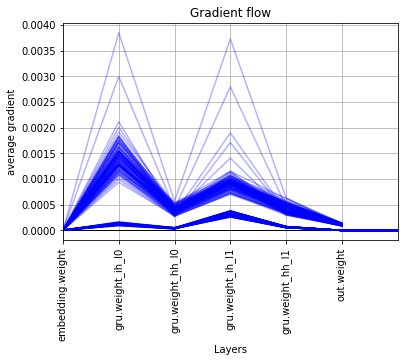

In [26]:
clip=50.0
teacher_forcing_ratio=1.0
learning_rate=0.0001
decoder_learning_ratio=5.0
n_iteration=100
print_every=1
save_every=200

save_dir="not defined"

encoder.train()
decoder.train()

# encoder.cuda()
# decoder.cuda()

encoder_optimizer=torch.optim.Adam(encoder.parameters(),lr=learning_rate)
decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=learning_rate*decoder_learning_ratio)

plotter=VisdomLinePlotter('main')


trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)





In [27]:
encoder.eval()
decoder.eval()

DecoderRNN(
  (embedding): Embedding(7816, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (out): Linear(in_features=500, out_features=7816, bias=True)
)

In [28]:
searcher=GreedySearchDecoder(encoder,decoder)
evaluateInput(encoder,decoder,searcher,voc)

Human> hello
The Normalized Input Sentence: hello
Indexed sentence: [[787, 2]]
The Lengths tensor: tensor([2])
Decoder hidden state: tensor([[[-5.7629e-01,  2.6459e-01, -3.1873e-01,  8.4648e-01, -4.1809e-01,
           9.0641e-02, -5.4184e-01,  1.6064e-01,  5.3296e-01,  3.3377e-01,
           3.2582e-01,  5.9243e-01,  1.3309e-01, -2.0969e-01,  1.6529e-01,
           6.5829e-01,  4.7147e-01,  4.5388e-01,  1.0646e-01, -1.5538e-01,
          -5.6214e-01, -2.7612e-01,  3.3099e-01, -3.6861e-01,  8.2402e-02,
          -3.3271e-01,  2.3670e-01,  5.8843e-02,  4.0869e-01,  4.1179e-01,
           3.9621e-01,  8.7089e-01, -6.7841e-01, -8.5188e-01,  8.2205e-02,
          -1.2608e-01,  5.4845e-01, -5.9291e-01,  2.4559e-01, -1.7653e-01,
           6.5996e-01, -1.7913e-01,  6.2353e-01,  3.5044e-01, -7.7172e-01,
           2.9408e-01, -1.5232e-01, -1.0552e-01,  5.4817e-01,  1.1097e-01,
          -5.7606e-01, -4.6250e-02, -2.6945e-01,  5.3157e-01, -7.2428e-01,
          -8.1419e-01,  2.5470e-02,  5.849

       device='cuda:0', grad_fn=<SliceBackward>)
Decoder's Input: tensor([[1]], device='cuda:0')
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device

       grad_fn=<SliceBackward>)
Decoder's Input: tensor([[1]], device='cuda:0')
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
      

In [35]:
sentence="hello"
indexes_batch=[indexesFromSentence(voc,sentence)]
lengths=torch.tensor([len(index) for index in indexes_batch])
input_batch=torch.LongTensor(indexes_batch).transpose(0,1)
input_batch=input_batch.to(device)
lengths=lengths.to(device)
encoder_outputs,encoder_hidden=encoder(input_batch,lengths)
decoder_hidden=encoder_hidden[:decoder.n_layers]
print("decoder_hidden: "+str(decoder_hidden))
decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * START_Token
for _ in range(10):
    decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
    print("Decoder's Output: "+str(decoder_output))
    print("Decoder's output size: "+str(decoder_output.size()))
    decoder_scores,decoder_input=torch.max(decoder_output,dim=1)
    decoder_input=torch.unsqueeze(decoder_input,0)
    
    


decoder_hidden: tensor([[[-0.6731,  0.0014, -0.7550,  ...,  0.6316, -0.1078, -0.3748]],

        [[-0.1988,  0.2092,  0.1134,  ..., -0.0065, -0.2693, -0.3775]]],
       device='cuda:0', grad_fn=<SliceBackward>)
Decoder's Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder's output size: torch.Size([1, 7816])
Decoder's Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder's output size: torch.Size([1, 7816])
Decoder's Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder's output size: torch.Size([1, 7816])
Decoder's Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder's output size: torch.Size([1, 7816])
Decoder's Output: tensor([[1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ViewBackward>)
Decoder's output size: torch.Size([1, 7816])
Decoder's Output: tensor([[1.